# Using Kaggle to download the dataset

In [ ]:
from google.colab import files
import kagglehub

files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
path = kagglehub.dataset_download("eeshawn/flickr30k")
print(path)

100%|██████████| 4.08G/4.08G [00:35<00:00, 123MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


# Declaring Addresses


## Delaring Addresses

In [3]:
import os, shutil, glob

drive_base = "/content/drive/MyDrive/captioneer"
drive_scripts = os.path.join(drive_base, "scripts")
drive_captions = os.path.join(drive_base, "processed_captions")
drive_images_tar = os.path.join(drive_base, "processed_images.tar.gz")

colab_scripts = "/content/scripts"
colab_captions = "/content/processed_captions"
colab_images = os.path.join(path, "flickr30k_images")

os.makedirs(colab_scripts, exist_ok=True)
os.makedirs("/content/models", exist_ok=True)

## Copying Scripts

In [4]:
for fname in ["dataset_attention.py", "model_attention.py", 'model_transformer.py', 'dataset_transformer.py', 'model_lstm.py', 'dataset_lstm.py']:
    src = os.path.join(drive_scripts, fname)
    dst = os.path.join(colab_scripts, fname)
    if os.path.exists(dst):
        os.remove(dst)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied", fname, "to", dst)
    else:
        print("not found in drive:", src)
print("Scripts placed in", colab_scripts)

Copied dataset_attention.py to /content/scripts/dataset_attention.py
Copied model_attention.py to /content/scripts/model_attention.py
Copied model_transformer.py to /content/scripts/model_transformer.py
Copied dataset_transformer.py to /content/scripts/dataset_transformer.py
Copied model_lstm.py to /content/scripts/model_lstm.py
Copied dataset_lstm.py to /content/scripts/dataset_lstm.py
Scripts placed in /content/scripts


## Copying `processed_captions`

In [5]:
import glob

# copy captions folder
if os.path.exists(colab_captions):
    print("Removing existing", colab_captions)
    shutil.rmtree(colab_captions)
shutil.copytree(drive_captions, colab_captions)
print("Copied processed captions to", colab_captions)

# quick checks
images = glob.glob(os.path.join(colab_images, "*.jpg"))
print("Number of images:", len(images))
json_files = glob.glob(os.path.join(colab_captions, "*.json"))
print("Processed captions files:", json_files)

Copied processed captions to /content/processed_captions
Number of images: 31783
Processed captions files: ['/content/processed_captions/sequences_test.json', '/content/processed_captions/cleaned_captions.json', '/content/processed_captions/sequences_val.json', '/content/processed_captions/meta.json', '/content/processed_captions/vocab_word2idx.json', '/content/processed_captions/sequences_train.json', '/content/processed_captions/vocab_idx2word.json']


## Copy & Extracting `processed_images.tar.gz`

In [6]:
import tarfile

extracted_images = "/content/processed_images/"

# remove existing folder if present
if os.path.exists(extracted_images):
    shutil.rmtree(extracted_images)

# copy tar.gz from Drive to /content
tmp_tar = "/content/processed_images.tar.gz"
if os.path.exists(tmp_tar):
    os.remove(tmp_tar)
shutil.copy(drive_images_tar, tmp_tar)
print("Copied tarball to", tmp_tar)

# extract
with tarfile.open(tmp_tar, "r:gz") as tar:
    tar.extractall(path=extracted_images)
print("Extraction complete. Images directory:", extracted_images)


Copied tarball to /content/processed_images.tar.gz


/tmp/ipython-input-3770673435.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extracted_images)


Extraction complete. Images directory: /content/processed_images/


# Evaluation

## Creating Models, Dataloaders

In [7]:
!pip install pycocotools -q
!pip install pycocoevalcap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.2 MB/s eta 0:00:00


In [9]:
import os, sys, json, torch
sys.path.append('/content/scripts')
import numpy as np
from torch.utils.data import DataLoader, Subset
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import model_lstm, model_attention, model_transformer
import dataset_lstm, dataset_attention, dataset_transformer
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

reload(model_lstm); reload(model_attention); reload(model_transformer)
reload(dataset_lstm); reload(dataset_attention); reload(dataset_transformer)

def sequence_to_text(seq, idx2word_map):
    return ' '.join([idx2word_map.get(idx, "<UNK>") for idx in seq if idx not in {start_token, end_token, pad_token}])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_seq = '/content/processed_captions/sequences_test.json'
vocab_path = '/content/processed_captions/vocab_word2idx.json'



with open('/content/processed_captions/vocab_word2idx.json', "r", encoding="utf-8") as f:
    word2idx = json.load(f)
with open('/content/processed_captions/vocab_idx2word.json', "r", encoding="utf-8") as f:
    raw_idx2 = json.load(f)
idx2word = {int(k): v for k, v in raw_idx2.items()}
start_token = word2idx.get("<START>", 2)
end_token = word2idx.get("<END>", 3)
pad_token = word2idx.get("<PAD>", 0)




# Loading LSTM State And Encoder / Decoder
enc_lstm = model_lstm.EncoderIdentity(
    feat_dim=2048,
    embed_dim=1024
).to(device)
dec_lstm = model_lstm.DecoderRNN(
    embed_dim=512,
    hidden_dim=1024,
    vocab_size=len(word2idx),
    feat_embed_dim=1024
).to(device)

state_lstm = torch.load('/content/drive/MyDrive/captioneer/models_baseline/best_model_epoch4_bleu0.0523.pt', map_location=device)
enc_lstm.load_state_dict(state_lstm.get('encoder_state', state_lstm.get('encoder', state_lstm.get('encoder_state', {}))))
dec_lstm.load_state_dict(state_lstm.get('decoder_state', state_lstm.get('decoder', state_lstm.get('decoder_state', {}))))

enc_lstm.eval()
dec_lstm.eval()

lstm_test_ds = dataset_lstm.CaptionFeatureDataset(test_seq, extracted_images, vocab_path)
lstm_test_loader = DataLoader(lstm_test_ds, batch_size=1, shuffle=False)




# Loading LSTM + ATTENTION State And Encoder / Decoder
enc_attention = model_attention.EncoderCNN(
    feat_dim=2048,
    feat_embed_dim=512
).to(device)
dec_attention = model_attention.DecoderWithAttention(
    embed_dim=512,
    hidden_dim=1024,
    vocab_size=len(word2idx),
    feat_embed_dim=512
).to(device)

state_attention = torch.load('/content/drive/MyDrive/captioneer/models_attention/best_model_epoch14_bleu0.2049.pt', map_location=device)
enc_attention.load_state_dict(state_attention['encoder_state'])
dec_attention.load_state_dict(state_attention['decoder_state'])

enc_attention.eval()
dec_attention.eval()

attention_test_ds = dataset_attention.CaptionImageDataset(test_seq, colab_images, vocab_path, is_val=True)
attention_test_loader = DataLoader(attention_test_ds, batch_size=1, shuffle=True, collate_fn=dataset_attention.collate_fn)




# Loading Transformer State And Encoder / Decoder
enc_transformer = model_transformer.EncoderCNN(
    feat_embed_dim=768
).to(device)
dec_transformer = model_transformer.DecoderWithTransformer(
    vocab_size=len(word2idx),
    embed_dim=768,
    n_heads=4,
    decoder_layers=3,
    dim_feedforward=1024,
    dropout=0.1,
    device=device,
    word2idx=word2idx
).to(device)

state_transformer = torch.load('/content/drive/MyDrive/captioneer/models_transformer/best_model_epoch8_bleu0.2239.pt', map_location=device)
enc_transformer.load_state_dict(state_transformer['encoder_state'])
dec_transformer.load_state_dict(state_transformer['decoder_state'])

enc_transformer.eval()
dec_transformer.eval()

transformer_test_ds = dataset_transformer.CaptionImageDataset(test_seq, colab_images, vocab_path, is_val=True)
transformer_test_loader = DataLoader(transformer_test_ds, batch_size=1, shuffle=True, collate_fn=dataset_transformer.collate_fn)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


Loading DistilBERT model to extract word embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Initializing embedding layer for vocabulary of size 4998...
Custom embedding layer created and initialized with DistilBERT weights.


## Evaluation Function

In [10]:
from tqdm.notebook import tqdm
from pycocoevalcap.spice.spice import Spice

def evaluate_all_metrics(encoder, decoder, test_loader, model_name, beam_width):
    print(f"\nEvaluating model: {model_name}")
    gts = {}
    res = {}

    # This is needed to get all 5 captions for every model, ensuring a fair test
    with open(test_seq, "r", encoding="utf-8") as f:
        all_test_seqs = json.load(f)

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Generating captions for {model_name}"):
            # Handle the two different types of datasets
            if model_name == 'lstm':
                features, _, img_names = batch
                features = features.to(device)
            else:
                images, _, img_names = batch
                images = images.to(device)

            img_key = img_names[0]

            # Generate prediction string
            if model_name == 'lstm':
                projected_features = encoder(features)
                prediction_tokens = decoder.greedy_decode(projected_features, start_token)
                prediction_text = sequence_to_text(prediction_tokens, idx2word)
            else:
                if model_name == 'lstmattention':
                      feats, _ = encoder(images)
                else: # Transformer
                      feats = encoder(images)
                prediction_tokens = decoder.beam_search_decode(
                    feats, start_token, end_token, beam_width=beam_width
                )[0]
                prediction_text = sequence_to_text(prediction_tokens, idx2word)

            res[img_key] = prediction_text

            # Store all 5 ground truth strings for this image
            if img_key not in gts:
                gt_token_lists = all_test_seqs[img_key]
                gts[img_key] = [sequence_to_text(seq, idx2word) for seq in gt_token_lists]

    print("Calculating scores")
    coco = COCO()

    # Create the ground truth dataset in the required format
    coco_gts_data = {
        'info': {'description': 'Flickr30k Captions'},
        'licenses': ['unknown'],
        'images': [],
        'annotations': []
    }

    img_id_map = {}
    ann_id_counter = 0
    for i, img_key in enumerate(gts.keys()):
        img_id_map[img_key] = i
        coco_gts_data['images'].append({'id': i})
        for caption in gts[img_key]:
            coco_gts_data['annotations'].append({
                'image_id': i,
                'caption': caption,
                'id': ann_id_counter
            })
            ann_id_counter += 1

    coco.dataset = coco_gts_data
    coco.createIndex()

    # Create the results list in the required format
    coco_res_list = []
    for img_key, caption in res.items():
        if img_key in img_id_map:
            coco_res_list.append({'image_id': img_id_map[img_key], 'caption': caption})

    coco_res = coco.loadRes(coco_res_list)

    coco_eval = COCOEvalCap(coco, coco_res)
    coco_eval.evaluate()

    return coco_eval.eval

## Evaluating Models

In [11]:
import pandas as pd

all_scores = {}

all_scores['LSTM'] = evaluate_all_metrics(enc_lstm, dec_lstm, lstm_test_loader, 'lstm', 1)
all_scores['LSTM Attention'] = evaluate_all_metrics(enc_attention, dec_attention, attention_test_loader, 'lstmattention', 5)
all_scores['Transformer'] = evaluate_all_metrics(enc_transformer, dec_transformer, transformer_test_loader, 'transformer', 5)


Evaluating model: lstm


Generating captions for lstm:   0%|          | 0/15703 [00:00<?, ?it/s]

Calculating scores
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 3179, 'reflen': 24434, 'guess': [3179, 0, 0, 0], 'correct': [1845, 0, 0, 0]}
ratio: 0.13010559057051116
Bleu_1: 0.001
Bleu_2: 0.000
Bleu_3: 0.000
Bleu_4: 0.000
computing METEOR score...
METEOR: 0.091
computing Rouge score...
ROUGE_L: 0.088
computing CIDEr score...
CIDEr: 0.008
computing SPICE score...
SPICE: 0.026

Evaluating model: lstmattention


Generating captions for lstmattention:   0%|          | 0/3179 [00:00<?, ?it/s]

Calculating scores
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 32673, 'reflen': 32511, 'guess': [32673, 29494, 26315, 23136], 'correct': [20378, 9021, 3823, 1687]}
ratio: 1.0049829288548182
Bleu_1: 0.624
Bleu_2: 0.437
Bleu_3: 0.303
Bleu_4: 0.212
computing METEOR score...
METEOR: 0.178
computing Rouge score...
ROUGE_L: 0.434
computing CIDEr score...
CIDEr: 0.398
computing SPICE score...
SPICE: 0.120

Evaluating model: transformer


Generating captions for transformer:   0%|          | 0/3179 [00:00<?, ?it/s]

Calculating scores
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 32008, 'reflen': 31966, 'guess': [32008, 28829, 25650, 22471], 'correct': [20480, 9272, 4084, 1814]}
ratio: 1.001313896014484
Bleu_1: 0.640
Bleu_2: 0.454
Bleu_3: 0.320
Bleu_4: 0.227
computing METEOR score...
METEOR: 0.186
computing Rouge score...
ROUGE_L: 0.445
computing CIDEr score...
CIDEr: 0.451
computing SPICE score...
SPICE: 0.129


## Displaying Scores

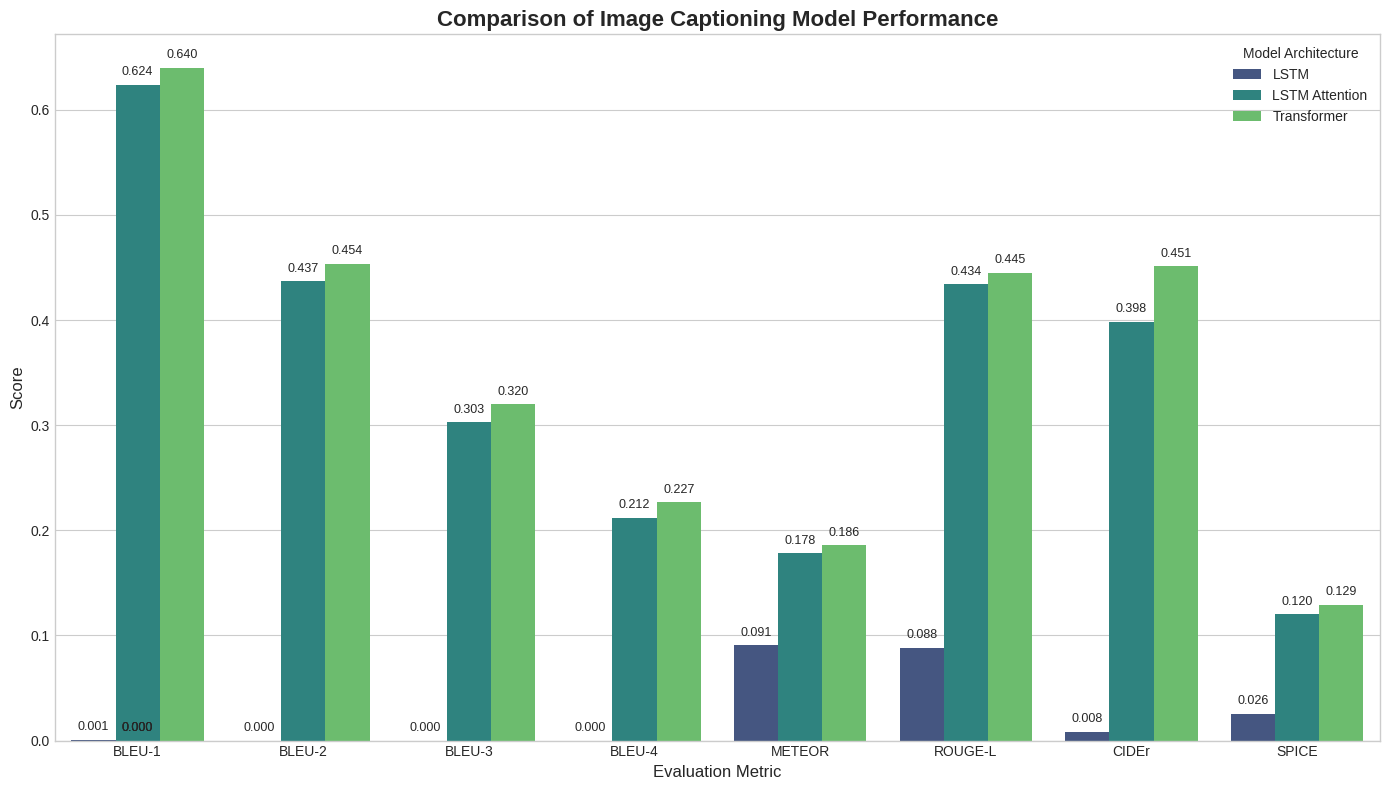

In [14]:
df = pd.DataFrame(all_scores).T
df = df.rename(columns={
    'Bleu_1': 'BLEU-1', 'Bleu_2': 'BLEU-2', 'Bleu_3': 'BLEU-3', 'Bleu_4': 'BLEU-4',
    'METEOR': 'METEOR', 'ROUGE_L': 'ROUGE-L', 'CIDEr': 'CIDEr', 'SPICE': 'SPICE'
})

df_chart = df_display.reset_index().rename(columns={'index': 'Model'}).melt(
    id_vars='Model',
    var_name='Metric',
    value_name='Score'
)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data=df_chart, x='Metric', y='Score', hue='Model', ax=ax, palette='viridis')

ax.set_title('Comparison of Image Captioning Model Performance', fontsize=16, weight='bold')
ax.set_xlabel('Evaluation Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Model Architecture', fontsize=10)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=9)

plt.tight_layout()
plt.show()